In [1]:
import sys
sys.path.append('../60_gebastel/Model/')
sys.path.append('../30_data_tools/')

In [82]:
from io import BytesIO
from pytorch_model_tools import get_datasets
from file_interaction import download_blob
from tqdm.auto import tqdm
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pickle
import math
import pandas as pd
import re
from helper import load_dotenv
import sqlite3
from get_labelstudio_data import get_results_of_project

from PIL import Image
from PIL import ImageFont, ImageDraw  
from pathlib import Path

In [81]:
dotenv = load_dotenv()
con = sqlite3.connect( dotenv['DB_PATH'] )

## noch offen

- ROC-Kurve/Area under Curve

0 = moire, 1 = no moire

In [4]:
def load_data( model_results_name ):
    data = pickle.loads( download_blob(f'model_results/{ model_results_name }.pkl').getbuffer() )
    data.rename(columns={'category':'label'}, inplace=True)
    
    data.loc[:,'predicted_label'] = (data.result_moire < data.result_no_moire).astype('int').apply(lambda val: ['moire','no_moire'][val])
    data.loc[:,'classification_correct'] = data.predicted_label == data.label

    data = pd.merge(
        data,
        data.tile_name.str.extract('(.+)_(\d+)\.\d+\.jpg').rename(columns={0:'mask_id',1:'dpi'}),
        left_index=True,
        right_index=True
    )
    
    return data

In [5]:
def calc_metrics( data ):
    TP = data.loc[(data.label == 'moire') & (data.predicted_label == 'moire')].shape[0]
    TN = data.loc[(data.label == 'no_moire') & (data.predicted_label == 'no_moire')].shape[0]
    FP = data.loc[(data.label == 'no_moire') & (data.predicted_label == 'moire')].shape[0]
    FN = data.loc[(data.label == 'moire') & (data.predicted_label == 'no_moire')].shape[0]

    out = {
        "count_data" : data.shape[0],
        "TP" : TP,
        "TN" : TN,
        "FP" : FP,
        "FN" : FN,
        "TN-Rate" : 0,
        "TP-Rate" : 0,
        "accuracy" : 0,
        "precision" : 0,
        "recall" : 0
    }
    
    if (FP + TN) > 0:
        out["TN-Rate"] = TN / (FP + TN)

    if (FN + TP) > 0:
        out["TP-Rate"] = TP / (FN + TP)

    if out['count_data'] > 0:
        out["accuracy"] = (TP + TN) / out['count_data']

    if (TP + FP) > 0:
        out["precision"] = TP / (TP + FP)

    if (TP + FN) > 0:
        out["recall"] = TP / (TP + FN)
    

    return out

In [6]:
def get_confusion_matrix( metrics, relative=False ):
    values = np.array([
        [metrics['TP'],metrics['FN']],
        [metrics['FP'],metrics['TN']]
    ])

    if relative:
        values = values / metrics['count_data']
    
    return px.imshow(
        values,
        x=['moire','no_moire'],
        y=['moire','no_moire'],
        labels={
            'y' : 'label',
            'x' : 'prediction'
        },
        text_auto=True
    )

In [15]:
def get_roc( data, threshold ):
    selection_moire = data.loc[data.result_moire > threshold]
    selection_no_moire = data.loc[data.result_moire <= threshold]
    TP = selection_moire.loc[selection_moire.label == 'moire'].shape[0]
    FP = selection_moire.loc[selection_moire.label == 'no_moire'].shape[0]
    TN = selection_no_moire.loc[selection_no_moire.label == 'no_moire'].shape[0]
    FN = selection_no_moire.loc[selection_no_moire.label == 'moire'].shape[0]

    TP_rate = TP / (TP + FN)
    FP_rate = FP / (FP + TN)

    return TP_rate, FP_rate


In [17]:
def get_tile_result_grid( data, img_size=224, col_count=5, label_type='both' ):
    label_names = ['moire','no_moire']
    row_count = math.ceil(data.shape[0] / col_count)

    out_img = Image.new(
        'RGB',
        (img_size * col_count, img_size * row_count),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]

    for i in range(data.shape[0]):
        row = i // col_count
        col = i % col_count

        result = data.iloc[i]
        tile_path = dotenv['TILE_DATASET_DIR'] / dataset_name / result.dataset / result.label / result.tile_name
        tile_img = Image.open( tile_path )
        out_img.paste(
            tile_img,
            ( col * tile_img.size[0], row * tile_img.size[1] )
        )
        draw.rectangle(
            (
                ( col * tile_img.size[0], row * tile_img.size[1] + round(img_size * 0.9) ),
                ( col * tile_img.size[0] + img_size, row * tile_img.size[1] + img_size )
            ),
            outline=None,
            fill=label_color[0] if result.classification_correct else label_color[1]
        )

        if label_type == 'label_name':
            label_text = f'{ result.predicted_label }/{ result.label }'
        elif label_type == 'moire_value':
            label_text = str( round(result.result_moire, 5) )
        elif label_type == 'description_values':
            label_text = f'{ round(result.frequency_gain, 5) }/{ round(result.ssim_value, 5) }'
        else:
            label_text = f'{ result.predicted_label }/{ result.label } - {round(result.result_moire, 5)}'
        
        draw.text(
            ( col * tile_img.size[0] + round(img_size * 0.5), row * tile_img.size[1] + round(img_size * 0.97) ),
            label_text,
            anchor='ms',
            font_size=15
        )
    
    return out_img

# Auswertung

In [7]:
model_name = '2024-05-04_Resnet50_002'
dataset_name = '24-05-04_001_tile_dataset'

In [8]:
data = load_data(f"{ model_name }_{ dataset_name }")

In [9]:
metrics = {}

for dataset in data.dataset.unique():
    metrics[dataset] = calc_metrics( data.loc[data.dataset == dataset] )

In [10]:
metrics_df = pd.DataFrame.from_dict([metrics[key] for key in metrics])
metrics_df.loc[:,'dataset'] = [key for key in metrics]
metrics_df.set_index('dataset', inplace=True)

metrics_df.T

dataset        real_val          test         train          val
count_data  7300.000000  24822.000000  74373.000000  9656.000000
TP          1439.000000   9244.000000  28090.000000  3247.000000
TN          2299.000000  13806.000000  43590.000000  5566.000000
FP           433.000000    907.000000   1689.000000   408.000000
FN          3129.000000    865.000000   1004.000000   435.000000
TN-Rate        0.841508      0.938354      0.962698     0.931704
TP-Rate        0.315018      0.914433      0.965491     0.881858
accuracy       0.512055      0.928612      0.963791     0.912697
precision      0.768697      0.910649      0.943282     0.888372
recall         0.315018      0.914433      0.965491     0.881858

In [73]:
real_val_tiles = [tile_path.name for tile_path in (dotenv['TILE_DATASET_DIR'] / 'real_val').glob('./**/*.jpg')]
real_val_tiles = sorted(real_val_tiles)

In [74]:
data.loc[
    (data.tile_name.isin(real_val_tiles)) &
    (data.label != data.predicted_label)
].sort_values('result_moire')

tile_name     label   dataset  result_moire  \
3027            3saIbm2bXB_200.0028.jpg     moire  real_val  1.077737e-08   
2876            yV79qsNBQ7_300.0051.jpg     moire  real_val  2.184700e-08   
5320            rO96sPXay9_200.0067.jpg     moire  real_val  3.232389e-08   
4220            0P2Uej9a6y_200.0010.jpg     moire  real_val  4.236392e-08   
3166            lcNOMr3S0B_200.0025.jpg     moire  real_val  5.761762e-08   
...                                 ...       ...       ...           ...   
408   8XxE_XE7X3_ok_sample_150.0016.jpg  no_moire  real_val  1.000000e+00   
2388  uk96bJG76E_ok_sample_200.0008.jpg  no_moire  real_val  1.000000e+00   
1916  a9Aqgyu95J_ok_sample_200.0003.jpg  no_moire  real_val  1.000000e+00   
2163  8XxE_XE7X3_ok_sample_150.0018.jpg  no_moire  real_val  1.000000e+00   
9     uk96bJG76E_ok_sample_200.0007.jpg  no_moire  real_val  1.000000e+00   

      result_no_moire predicted_label  classification_correct  \
3027     1.000000e+00        no_moire                   False   
2876     1.000000e+00        no_moire                   False   
5320     1.000000e+00        no_moire                   False   
4220     1.000000e+00        no_moire                   False   
3166     1.000000e+00        no_moire                   False   
...               ...             ...                     ...   
408      1.964831e-10           moire                   False   
2388     2.232310e-09           moire                   False   
1916     8.730404e-10           moire                   False   
2163     1.964831e-10           moire                   False   
9        2.232310e-09           moire                   False   

                   mask_id  dpi  
3027            3saIbm2bXB  200  
2876            yV79qsNBQ7  300  
5320            rO96sPXay9  200  
4220            0P2Uej9a6y  200  
3166            lcNOMr3S0B  200  
...                    ...  ...  
408   8XxE_XE7X3_ok_sample  150  
2388  uk96bJG76E_ok_sample  200  
1916  a9Aqgyu95J_ok_sample  200  
2163  8XxE_XE7X3_ok_sample  150  
9     uk96bJG76E_ok_sample  200  

[3362 rows x 9 columns]

In [91]:
data.loc[
    data.tile_name.isin(real_val_tiles)
]

pd.merge(
    data,
    pd.DataFrame([(m['id'],m['img_name']) for m in get_results_of_project(3) if 'id' in m]).rename(columns={0:'mask_id',1:'img_name'}),
    how="left",
    on="mask_id"
)

tile_name     label   dataset  result_moire  \
0       TY9ECj6DfD_ok_sample_300.0002.jpg  no_moire  real_val      0.000004   
1       qFlIydxiVt_ok_sample_200.0025.jpg  no_moire  real_val      0.010799   
2       1g1puC6grK_ok_sample_200.0008.jpg  no_moire  real_val      0.003093   
3       xt0-IVVwTJ_ok_sample_300.0026.jpg  no_moire  real_val      0.003093   
4       PLycOxJFl2_ok_sample_300.0009.jpg  no_moire  real_val      0.003093   
...                                   ...       ...       ...           ...   
116146            b01LFBfeP-_300.0050.jpg     moire       val      1.000000   
116147            oNwh5lV7z0_300.0003.jpg     moire       val      1.000000   
116148            oNwh5lV7z0_300.0017.jpg     moire       val      1.000000   
116149            b01LFBfeP-_300.0044.jpg     moire       val      0.999999   
116150            Ls3D8z6H6a_300.0029.jpg     moire       val      0.617240   

        result_no_moire predicted_label  classification_correct  \
0          9.999957e-01        no_moire                    True   
1          9.892011e-01        no_moire                    True   
2          9.969074e-01        no_moire                    True   
3          9.969074e-01        no_moire                    True   
4          9.969074e-01        no_moire                    True   
...                 ...             ...                     ...   
116146     1.992468e-07           moire                    True   
116147     3.030056e-16           moire                    True   
116148     2.724442e-12           moire                    True   
116149     1.254840e-06           moire                    True   
116150     3.827603e-01           moire                    True   

                     mask_id  dpi img_name  
0       TY9ECj6DfD_ok_sample  300      NaN  
1       qFlIydxiVt_ok_sample  200      NaN  
2       1g1puC6grK_ok_sample  200      NaN  
3       xt0-IVVwTJ_ok_sample  300      NaN  
4       PLycOxJFl2_ok_sample  300      NaN  
...                      ...  ...      ...  
116146            b01LFBfeP-  300      NaN  
116147            oNwh5lV7z0  300      NaN  
116148            oNwh5lV7z0  300      NaN  
116149            b01LFBfeP-  300      NaN  
116150            Ls3D8z6H6a  300      NaN  

[116151 rows x 10 columns]

In [95]:
[m for m in get_results_of_project(3) if 'id' in m and m['id'] == 'Ls3D8z6H6a']

[]

In [75]:
calc_metrics(
    data.loc[
        data.tile_name.isin(real_val_tiles)
    ]
)

{'count_data': 7075,
 'TP': 1414,
 'TN': 2299,
 'FP': 433,
 'FN': 2929,
 'TN-Rate': 0.8415080527086384,
 'TP-Rate': 0.32558139534883723,
 'accuracy': 0.5248056537102473,
 'precision': 0.7655657823497564,
 'recall': 0.32558139534883723}

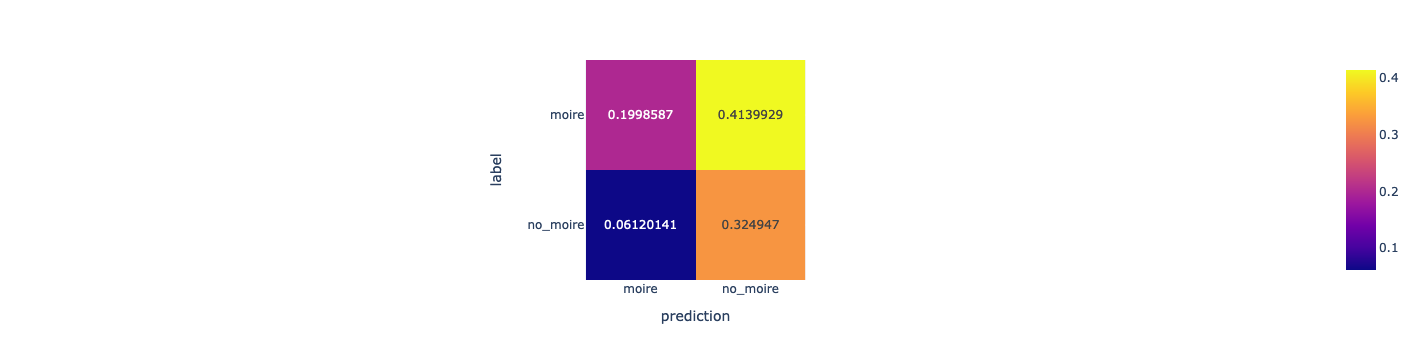

In [77]:
get_confusion_matrix(
    calc_metrics(
    data.loc[
            data.tile_name.isin(real_val_tiles)
        ]
    ),
    relative=True
)

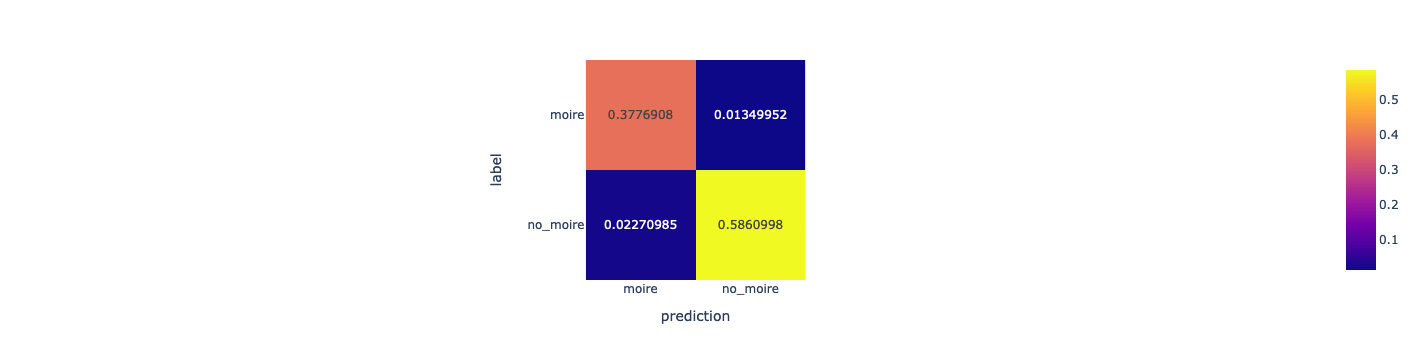

In [11]:
get_confusion_matrix( metrics['train'], relative=True )

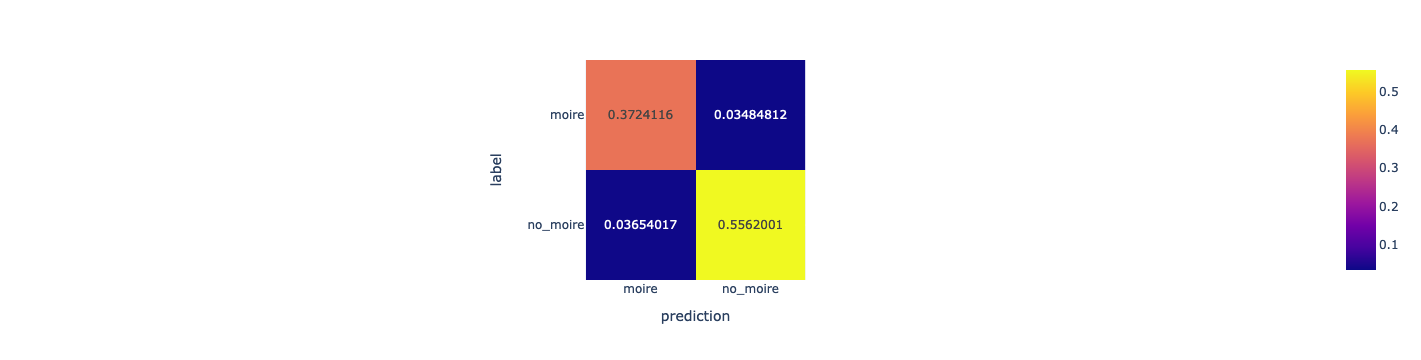

In [12]:
get_confusion_matrix( metrics['test'], relative=True )

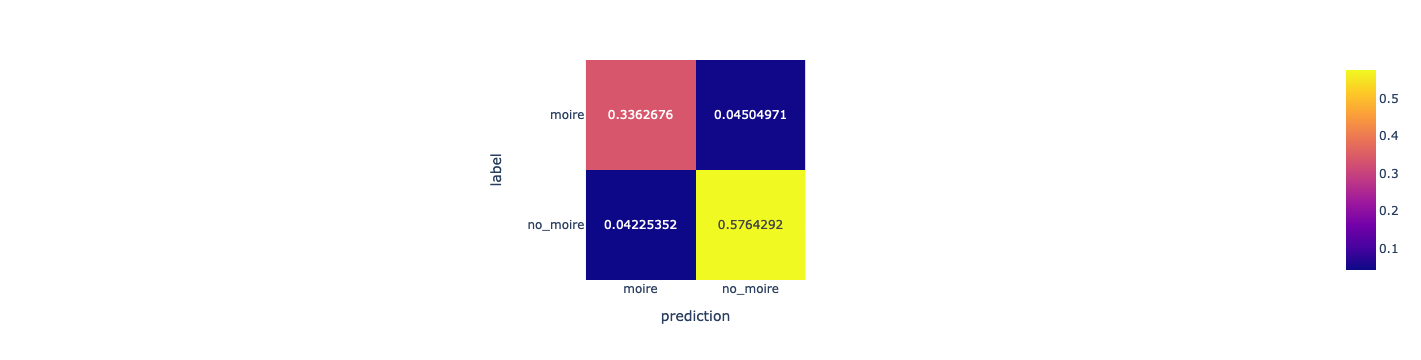

In [13]:
get_confusion_matrix( metrics['val'], relative=True )

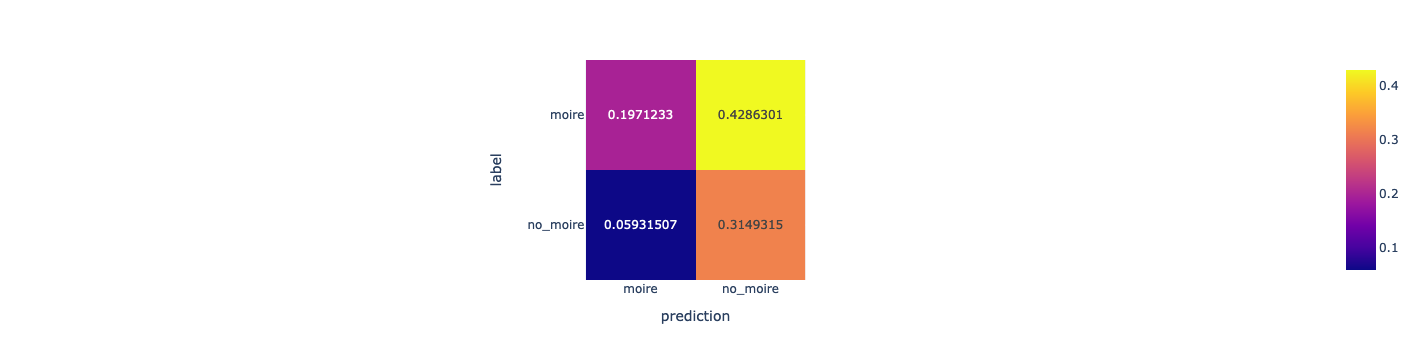

In [14]:
get_confusion_matrix( metrics['real_val'], relative=True )

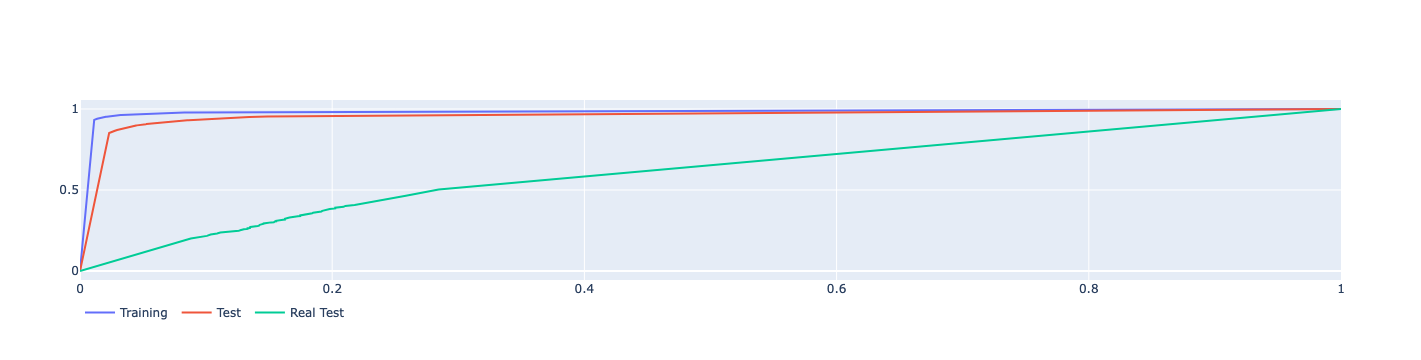

In [16]:
fig = go.Figure()

roc_train = [get_roc(data.loc[data.dataset == 'train'], i / 100) for i in range(101)]
roc_test = [get_roc(data.loc[data.dataset == 'test'], i / 100) for i in range(101)]
roc_real_val = [get_roc(data.loc[data.dataset == 'real_val'], i / 100) for i in range(101)]

fig.add_trace(go.Scatter(
    x=[r[1] for r in roc_train],
    y=[r[0] for r in roc_train],
    mode="lines",
    name="Training"
))
fig.add_trace(go.Scatter(
    x=[r[1] for r in roc_test],
    y=[r[0] for r in roc_test],
    mode="lines",
    name="Test"
))
fig.add_trace(go.Scatter(
    x=[r[1] for r in roc_real_val],
    y=[r[0] for r in roc_real_val],
    mode="lines",
    name="Real Test"
))
fig.update_layout(legend={'orientation':'h'})

fig

# Kacheldataset

In [26]:
grouped_tile_dataset = data.loc[
    :,
    ['mask_id','dataset','label','dpi','predicted_label']
].groupby(['mask_id','label','dpi']).min().reset_index()
grouped_tile_dataset = grouped_tile_dataset.groupby(['mask_id','label']).agg(pd.Series.mode).reset_index().drop(columns=['dpi'])
grouped_tile_dataset = grouped_tile_dataset.loc[
    grouped_tile_dataset.predicted_label.apply(lambda val: type(val) == str)
]

In [38]:
tile_metrics_df = pd.DataFrame.from_dict([calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == dataset]) for dataset in grouped_tile_dataset.dataset.unique()])
tile_metrics_df.loc[:,'dataset'] = [dataset for dataset in grouped_tile_dataset.dataset.unique()]
tile_metrics_df.set_index('dataset', inplace=True)

tile_metrics_df.T

dataset          train         val        test    real_val
count_data  838.000000  119.000000  268.000000  195.000000
TP          418.000000   60.000000  131.000000   73.000000
TN          358.000000   44.000000   97.000000   71.000000
FP           58.000000   15.000000   36.000000   26.000000
FN            4.000000    0.000000    4.000000   25.000000
TN-Rate       0.860577    0.745763    0.729323    0.731959
TP-Rate       0.990521    1.000000    0.970370    0.744898
accuracy      0.926014    0.873950    0.850746    0.738462
precision     0.878151    0.800000    0.784431    0.737374
recall        0.990521    1.000000    0.970370    0.744898

In [39]:
calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == 'real_val'])

{'count_data': 195,
 'TP': 73,
 'TN': 71,
 'FP': 26,
 'FN': 25,
 'TN-Rate': 0.7319587628865979,
 'TP-Rate': 0.7448979591836735,
 'accuracy': 0.7384615384615385,
 'precision': 0.7373737373737373,
 'recall': 0.7448979591836735}

In [43]:
grouped_tile_dataset.loc[
    (grouped_tile_dataset.dataset == 'real_val') &
    (grouped_tile_dataset.label != grouped_tile_dataset.predicted_label)
]

mask_id     label   dataset predicted_label
19    -WZ0mafN9o_ok_sample  no_moire  real_val           moire
42              0P2Uej9a6y     moire  real_val        no_moire
43    0P2Uej9a6y_ok_sample  no_moire  real_val           moire
92              2kZ7k2bsXX     moire  real_val        no_moire
94              2oET487iOj     moire  real_val        no_moire
112             3Wpq5C5tW7     moire  real_val        no_moire
140             4Qx9pFW6Li     moire  real_val        no_moire
182             5ZQFwSl4aV     moire  real_val        no_moire
195   6AJHRUwWbm_ok_sample  no_moire  real_val           moire
212             73k4MDQ87_     moire  real_val        no_moire
240             8XxE_XE7X3     moire  real_val        no_moire
345   DbHEJveN10_ok_sample  no_moire  real_val           moire
368             Ei8I9p4ERo     moire  real_val        no_moire
384             FGxzdgm4qe     moire  real_val        no_moire
432             H5b9VdGlqL     moire  real_val        no_moire
441   HRSYZIWvHi_ok_sample  no_moire  real_val           moire
447   HkAVlhYwx9_ok_sample  no_moire  real_val           moire
510   Kw4g8dA8UX_ok_sample  no_moire  real_val           moire
532   MHMhYNiUCP_ok_sample  no_moire  real_val           moire
593             OknpNEbepT     moire  real_val        no_moire
612   Q-Um6O_Gd5_ok_sample  no_moire  real_val           moire
672   TTFrRmiOzV_ok_sample  no_moire  real_val           moire
699             UbH49PgBsY     moire  real_val        no_moire
708   UoXK_QYXKM_ok_sample  no_moire  real_val           moire
802   ZcwnyfFsCf_ok_sample  no_moire  real_val           moire
832   _suQoDRyTl_ok_sample  no_moire  real_val           moire
834   _toF01usDR_ok_sample  no_moire  real_val           moire
840   a9Aqgyu95J_ok_sample  no_moire  real_val           moire
875             cQt-RMX0dp     moire  real_val        no_moire
1027            jq9MesNgV8     moire  real_val        no_moire
1028  jq9MesNgV8_ok_sample  no_moire  real_val           moire
1069            lYYQeNF9Jl     moire  real_val        no_moire
1075            lcNOMr3S0B     moire  real_val        no_moire
1095            mOwgsHDous     moire  real_val        no_moire
1116  nB2Ksz_1qZ_ok_sample  no_moire  real_val           moire
1160  opNaumFlx-_ok_sample  no_moire  real_val           moire
1190  pyud3yJYkC_ok_sample  no_moire  real_val           moire
1202            qFlIydxiVt     moire  real_val        no_moire
1203  qFlIydxiVt_ok_sample  no_moire  real_val           moire
1212            qTeGpY4RLg     moire  real_val        no_moire
1229  rO96sPXay9_ok_sample  no_moire  real_val           moire
1265  sgESoxDBHJ_ok_sample  no_moire  real_val           moire
1276            tZjRGEqd5z     moire  real_val        no_moire
1311  uk96bJG76E_ok_sample  no_moire  real_val           moire
1369  x6ZdUYzZAq_ok_sample  no_moire  real_val           moire
1396            yG3y9j0rBQ     moire  real_val        no_moire
1398            yV79qsNBQ7     moire  real_val        no_moire
1399  yV79qsNBQ7_ok_sample  no_moire  real_val           moire
1400            yY0lKhhRm4     moire  real_val        no_moire
1401  yY0lKhhRm4_ok_sample  no_moire  real_val           moire
1418            zTSmtTDlzH     moire  real_val        no_moire

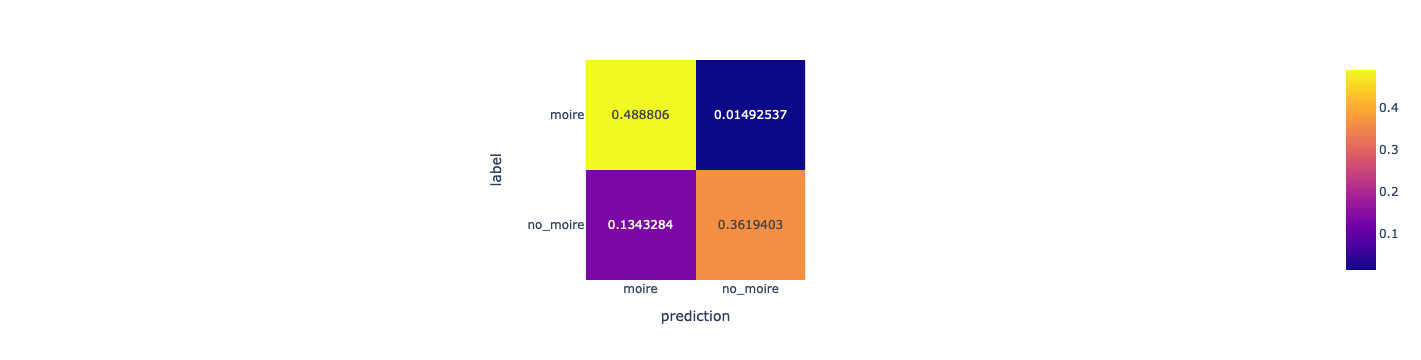

In [96]:
get_confusion_matrix( calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == 'test']), relative=True )

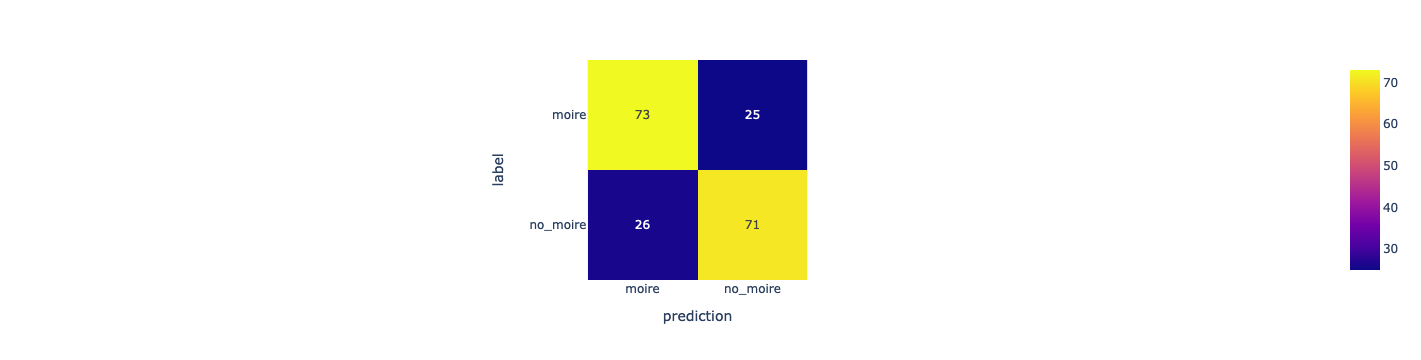

In [40]:
get_confusion_matrix( calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == 'real_val']) )

# Datenset nach Auflösung

In [ ]:
resolution_metrics = []

for dataset in ['test','real_val']:
    for resolution in data.loc[pd.isna(data.dpi) == False].dpi.unique():
        resolution_metric = calc_metrics(
            data.loc[
                (data.dataset == dataset) &
                (data.dpi == resolution)
            ]
        )

        resolution_metric['dataset'] = dataset
        resolution_metric['resolution'] = resolution
        resolution_metrics.append(resolution_metric)

In [ ]:
resolution_metrics_df = pd.DataFrame.from_dict(resolution_metrics)
resolution_metrics_df.set_index(['dataset','resolution'], inplace=True)
resolution_metrics_df

# Rest

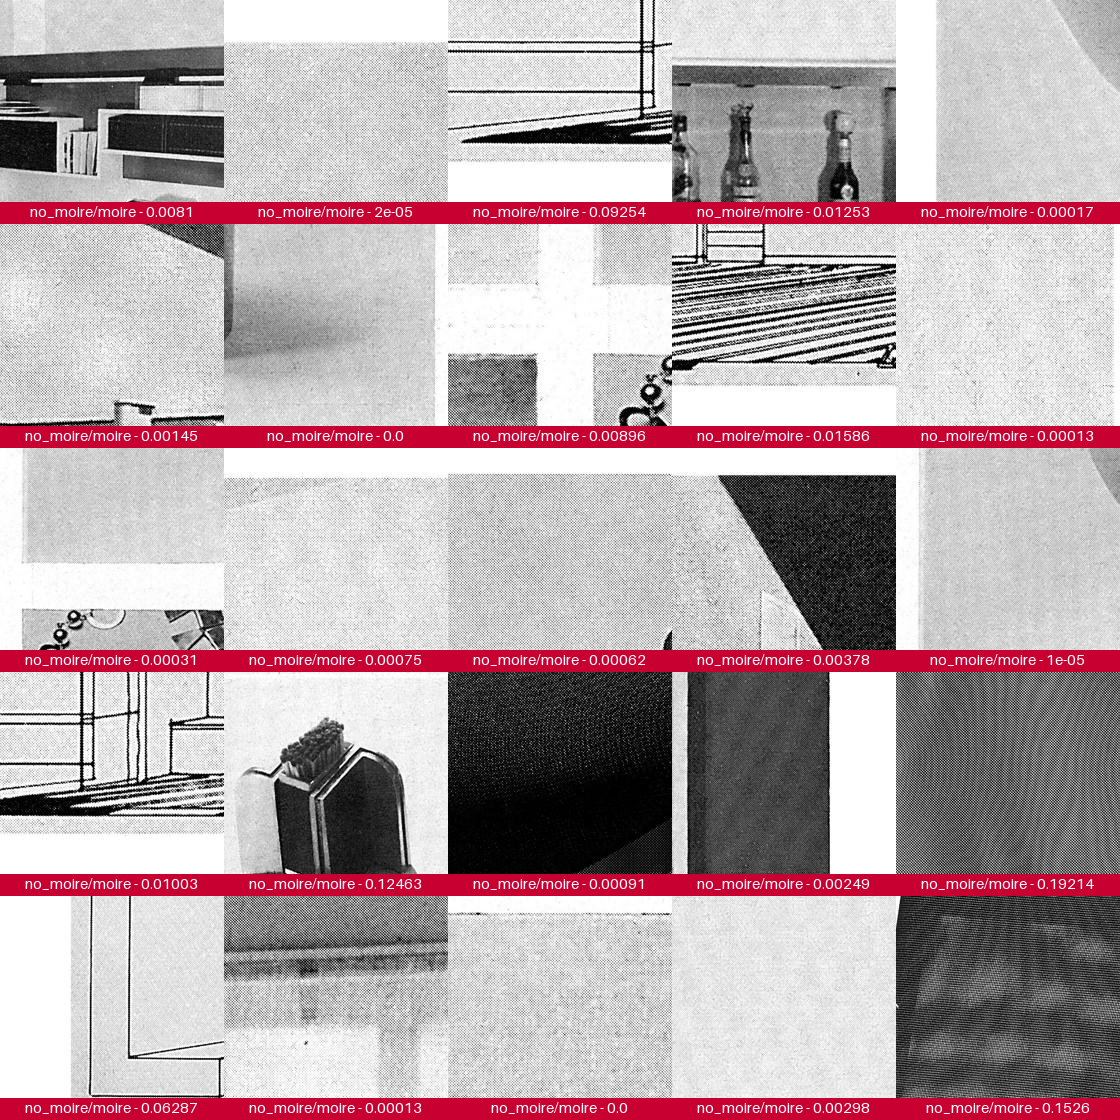

In [25]:
get_tile_result_grid(
    data.loc[
        (data.label == 'moire') &
        (data.predicted_label == 'no_moire') &
        (data.dataset == 'real_val')
    ].sample(frac=1).iloc[:25],
)

In [ ]:
result

In [ ]:
result = data.iloc[0]

In [ ]:
px.line(
    data.loc[
        (data.label == 'moire') &
        (data.predicted_label == 'no_moire') &
        (data.dataset == 'train')
    ].sort_values('result_moire').reset_index().result_moire
)

In [ ]:
data.loc[
    (data.label == 'moire') &
    (data.predicted_label == 'moire') &
    (data.dataset == 'train')
].sort_values('result_moire', ascending=False).iloc[:50]

In [ ]:
get_tile_result_grid(
    data.loc[
        (data.label == 'moire') &
        (data.predicted_label == 'moire') &
        (data.dataset == 'train')
    ].sort_values('result_moire', ascending=False).iloc[:50],
)

In [ ]:
def get_tile_result_grid( data, img_size=224, col_count=5, label_type='both' ):
    label_names = ['moire','no_moire']
    row_count = math.ceil(data.shape[0] / col_count)

    out_img = Image.new(
        'RGB',
        (img_size * col_count, img_size * row_count),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]

    for i in range(data.shape[0]):
        row = i // col_count
        col = i % col_count

        result = data.iloc[i]
        tile_path = dotenv['TILE_DATASET_DIR'] / dataset_name / result.dataset / result.label / result.tile_name
        tile_img = Image.open( tile_path )
        out_img.paste(
            tile_img,
            ( col * tile_img.size[0], row * tile_img.size[1] )
        )
        draw.rectangle(
            (
                ( col * tile_img.size[0], row * tile_img.size[1] + round(img_size * 0.9) ),
                ( col * tile_img.size[0] + img_size, row * tile_img.size[1] + img_size )
            ),
            outline=None,
            fill=label_color[0] if result.classification_correct else label_color[1]
        )

        if label_type == 'label_name':
            label_text = f'{ result.predicted_label }/{ result.label }'
        elif label_type == 'moire_value':
            label_text = str( round(result.result_moire, 5) )
        else:
            label_text = f'{ result.predicted_label }/{ result.label } - {round(result.result_moire, 5)}'
        
        draw.text(
            ( col * tile_img.size[0] + round(img_size * 0.5), row * tile_img.size[1] + round(img_size * 0.97) ),
            label_text,
            anchor='ms',
            font_size=15
        )
    
    return out_img

In [ ]:
results = []

for tile_path in tqdm(tile_paths):
    tile = Image.open(tile_path)
    transform = transforms.Compose([transforms.PILToTensor()])

    tensor = transform(tile) / 255
    tensor = tensor.reshape((1,3,224,224))
    with torch.no_grad():
        pred = model(tensor)

    results.append((
        tile_path,
        pred,
        int(torch.argmax(pred))
    ))

In [ ]:
font = ImageFont.load_default()

In [ ]:
IMG_SIZE = 224

label_names = ['moire','no_moire']
grid_size = (5,5)

offset = 0

while offset < len(results):
    out_img = Image.new(
        'RGB',
        (IMG_SIZE * grid_size[0], IMG_SIZE * grid_size[1]),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]
    
    for y in range(grid_size[1]):
        for x in range(grid_size[0]):
            i = y * grid_size[1] + x
    
            if len(results) > offset + i:
                result = results[offset+i]
                label = result[0].parent.name
                target_label = label_names[result[2]]
                
                tile_img = Image.open( result[0] )
                out_img.paste(
                    tile_img,
                    ( x * tile_img.size[0], y * tile_img.size[1] )
                )
                draw.rectangle(
                    (
                        ( x * tile_img.size[0], y * tile_img.size[1] + round(IMG_SIZE * 0.9) ),
                        ( x * tile_img.size[0] + IMG_SIZE, y * tile_img.size[1] + IMG_SIZE )
                    ),
                    outline=None,
                    fill=label_color[0] if label == target_label else label_color[1]
                )
                draw.text(
                    ( x * tile_img.size[0] + round(IMG_SIZE * 0.5), y * tile_img.size[1] + round(IMG_SIZE * 0.97) ),
                    f'{ label }/{ target_label }',
                    anchor='ms',
                    font_size=15
                )
                
    offset += 50
    out_img.save( f'/Users/frederic.birwe/Downloads/tile_grid_{ (str(offset)).zfill(3) }.jpg' )

out_img

In [ ]:
results